# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sajeevan"
ln1 = "puvikaran"
fn2 = "yanis"
ln2 = "daci"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_puvikaran_sajeevan_and_daci_yanis.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


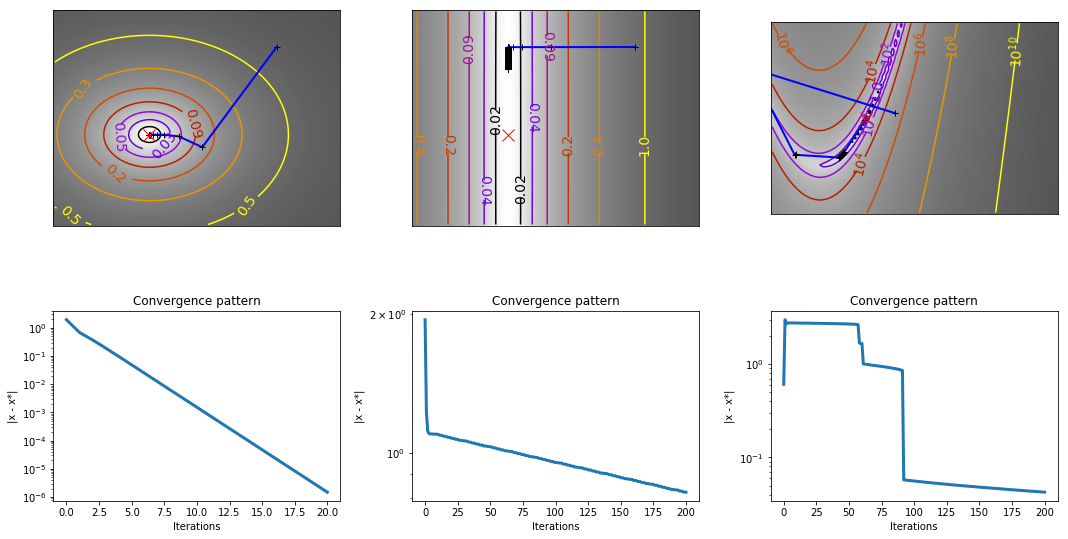

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [6]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold 
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))
    all_positive_eigenvalues = False

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        print("Gradient of f: %s" % grad_x)
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO
        H = f_hessian(x)
        if(np.linalg.eigvalsh(H)[0] <= lambda_threshold):
            H += (lambda_threshold - min(np.linalg.eigvalsh(H))) * np.identity(x.shape[0])
        d = -np.linalg.solve(H, grad_x)

        all_positive_eigenvalues = (np.linalg.eigvals(H) > 0)
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)
        
        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
    
    print("All eigenvalues are positive: %s" % all_positive_eigenvalues)
    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
Gradient of f: [0.23315693 0.31417896]
Gradient of f: [-0.23246589  0.48621351]
Gradient of f: [ 0.06760966 -0.24450703]
Gradient of f: [0.0012406  0.22199474]
Gradient of f: [ 2.80192668e-05 -2.02745813e-01]
Gradient of f: [5.23475929e-07 1.86730834e-01]
Gradient of f: [ 8.24437700e-09 -1.73081526e-01]
Gradient of f: [1.11021737e-10 1.61233877e-01]
Gradient of f: [ 1.29247962e-12 -1.50801709e-01]
Gradient of f: [1.31222385e-14 1.41509536e-01]
Gradient of f: [ 1.17018475e-16 -1.33154291e-01]
Gradient of f: [9.21984026e-19 1.25582217e-01]
Gradient of f: [ 6.45005059e-21 -1.18674247e-01]
Gradient of f: [4.02343668e-23 1.12336405e-01]
Gradient of f: [ 2.24588996e-25 -1.06493280e-01]
Gradient of f: [1.12534995e-27 1.01083488e-01]
All eigenvalues are positive: [ True  True]

Running solver on case 2
Gradient of f: [1.056e+00 2.904e-04]
All eigenvalues are positive: [ True  True]

Running solver on case 3
Gradient of f: [ 935.6 -292. ]
Gradient of f: [ 1.19858478e+0

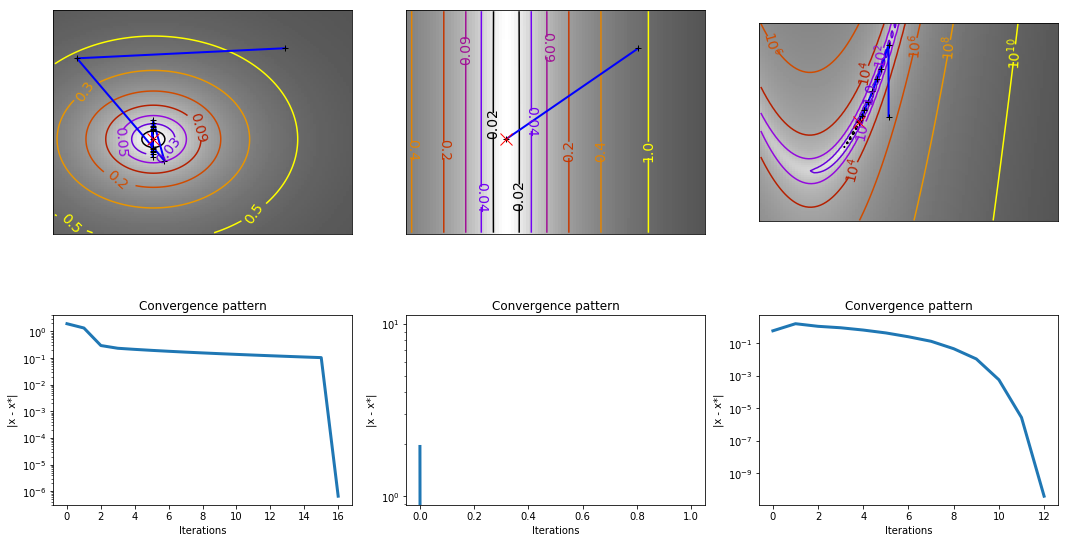

In [7]:
test_solver(newton)

**Comment:**

- First function: **Non Convex Gaussian kernel**:

In this case, the minimum eigenvalue of the Hessian is negative and so we do a regularization of the Hessian matrix (**line search**) in order to get only positive eigenvalues. Indeed, the convergence with Newton method requires positive eigenvalues. 

The Newton's Method consists on computing gradients and more precisely finding stationnary points. However, for a non convex function, the Newton's method does not distinguish between those stationnary points (local maxima or local minima). Therefore, the method would zigzag near the solution (turns around the solution). The distance between local minima and maxima will decrease at each iteration until they reach the stopping criteria: **l_inf_norm_grad < 1e-6**. Furthermore, as the function is **non convex**, regularization is hard and costly.
<br><br>


- Second function: **Badly conditioned quadratic function (but still strongly convex)**:

Newton's Method resolves quadratic problems exactly in 1 iteration. Indeed, the second order Taylor expansion is exact in this case. Newton's Method in the quadratic case does not depend on the conditionning (unlike gradient descent) and does not require the problem to be convex. 
<br><br>


- Third function: **Rosenbrock function**:

The Rosenbrock function contains "valleys" and it is called "banana function" because the global minimum is inside a long, narrow, parabolic shaped flat valley. Finding the valley is trivial. However, it is difficult to converge to the global minimum. Indeed, the method enters the valley (in the first iteration) before descending the entire valley. That's the reason why we have to complete 12 iterations to reach the minimum. We can see this phenomena visually on the graph. After the second iteration, it  comes slowly towards the solution which represents the valley descent. 
<br><br> 

**Study of parameters:**

- 1) c1 and c2:

>We should verify the **strong Wolfe's rule** :
- $\phi(t) \leq \phi(0) + c_1 \phi^{'}(0)t$ (Armijo's condition or linear decreasing condition)
- $|\phi^{'}(t)| \leq c_2 |\phi^{'}(0)|$

As written in the Scipy documentation, c1 is the **parameter for Armijo condition rule** and c2 is the **parameter for curvature condition rule**. For small c1 and c2 values, the Newton method takes less iterations to converge. For c1 small and c2 big values, we can see the curvature especially for the Rosenbrock function when the method is descending the valley. For big c1 and c2 values, the Newton takes much more iterations (more than 100) to converge (here linear convergence).  


**Interpretation**:


Indeed, when $c_1$ is near 0, we accept any value below $\phi(0)$. In practical, we select $c_1$ very small in order to satisfy the Armijo's condition easily. So, we have the choice of the step and we can find the best one. That's why we have selected $c_1 = 0.0001$. Thus, we have less iterations.

When $c_1$ is near 1, we reject most of the steps for convex functions and so, the step would not be optimal. Therefore, it will take more iterations.


When $c_2$ near 0, only points with $\phi^{'}(t) \geq 0$ are accepted.

When $c_2$ near 1, we accept all steps with a lower slope than $|\phi^{'}(0)|$. Thus, we have the choice between more steps.

To conclude, it is better to select a small $c_1$ value and a big value for $c_2$.

<br>
- 2) lambda_threshold - regularization threshold:

The bigger lambda_threshold is, the more there are iterations. Moreover, the convergence is linear for the 3 functions when lambda_threshold is big. 

For a bigger value of lambda_threshold, we will have a bigger value for the eigenvalues' minimum (if initially negative). Thus, we will lose in precision and it takes more iterations. 

**Conclusion**:<br>

The Newton method requires **less iterations to converge than** the gradient descent and particularly for the Rosenbruck function. Indeed, the Newton's Method takes into account the Hessian which is the curvature of the function. Thus, the Newton method descends "normally" the valley to find the minimum while the gradient descent "zigzags" when it descends the valley.
Moreover, Newton algorithm has a quadratic convergence while the gradient descent has a linear one.

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO 
        B = B + np.outer(s,s) / s.T.dot(y) - np.outer(B.dot(y), B.dot(y)) / y.T.dot(B).dot(y)
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


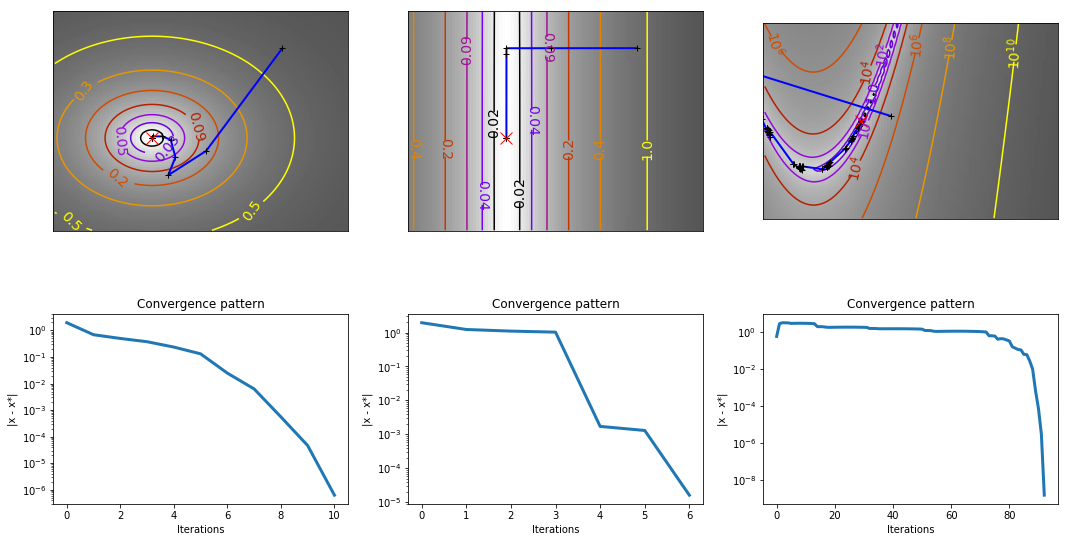

In [9]:
test_solver(dfp)

**Comment:**

The DFP algorithm **updates** the inverse B of the Hessian matrice.


- We can remark that the number of iterations has increased compared to the Newton method for the quadratic and the Rosenbrock functions. It is due to the update of the inverse of the Hessian matrice. Indeed, the DFP algorithm leads to rank 2 updates on $B_t$. Thus, the approximation of the Hessian will be less accurate because of the order of the updates. Thus, the search directions will be less good and it will take more iterations.


- There is a contradiction on the quadratic functions because, in class we have seen that a quadratic function of a positive Hessian A that satisfies $B_p = A^{-1}$ converges in $p+1$ iterations. But, in our example where $p = 2$, it converges after 6 iterations (it should have converged in 3 iterations). We can explain this contradiction by the fact that we do not have an optimal stepsize. Indeed, line search gives just a good enough stepsize.
  

# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO 
        rho = 1 / y.T.dot(s)
        B = (np.identity(len(x)) - (rho * np.outer(s,y))).dot(B).dot(np.identity(len(x)) - rho * (np.outer(y,s))) + rho * np.outer(s,s)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


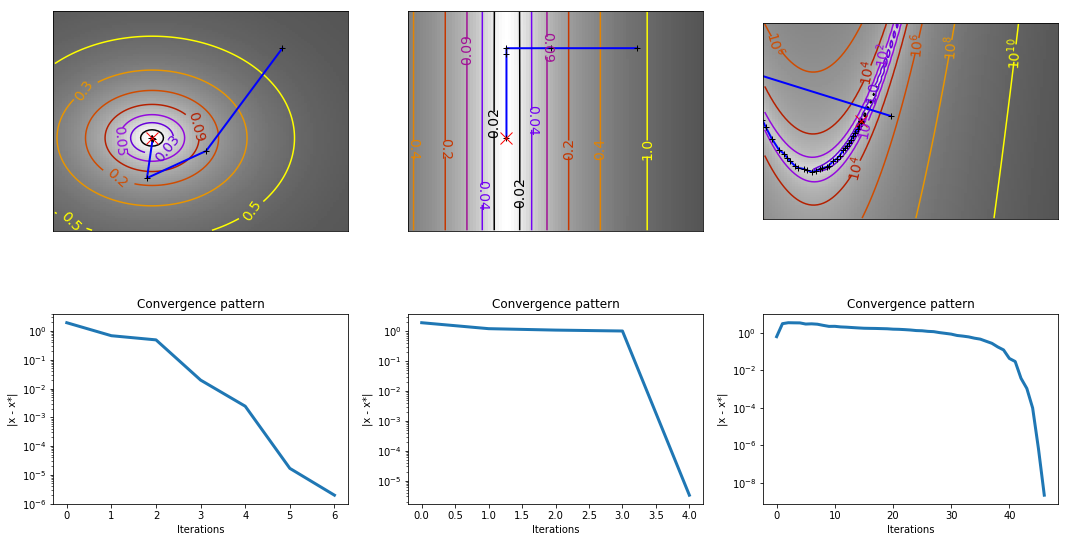

In [11]:
test_solver(bfgs)

Compared to DFP algorithm, the number of iterations to reach the convergence **has decreased**.

- BFGS has the same property as DFP for quadratic functions. It should converge in $p+1$ iterations (3 here). However, BFGS is less sensitive than DFP to errors in the line-search. The BFGS algorithm is less impacted by the use of approximate step size. Indeed, it converges in 4 iterations for the quadratic function. The result for BFGS is quite close to the property than the DFP one. Thus, the BFGS algorithm is more efficient.    


- For the Rosenbrock function, the method is able to follow the shape of the valley and converges to the minimum using only finite difference gradients.


# Part 4: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [12]:
def two_loops(grad_x, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''

    m = len(y_list)
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    for i in range(m):
        alpha_list.append(rho_list[i] * s_list[i].T.dot(q))
        q -= alpha_list[i] * y_list[i]

    r = np.dot(B0, q)

    # TODO: second loop
    for i in range(m):
        beta = rho_list[-(i+1)] * y_list[-(i+1)].T.dot(r)
        
        r += (alpha_list[-(i+1)] - beta) * s_list[-(i+1)]
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


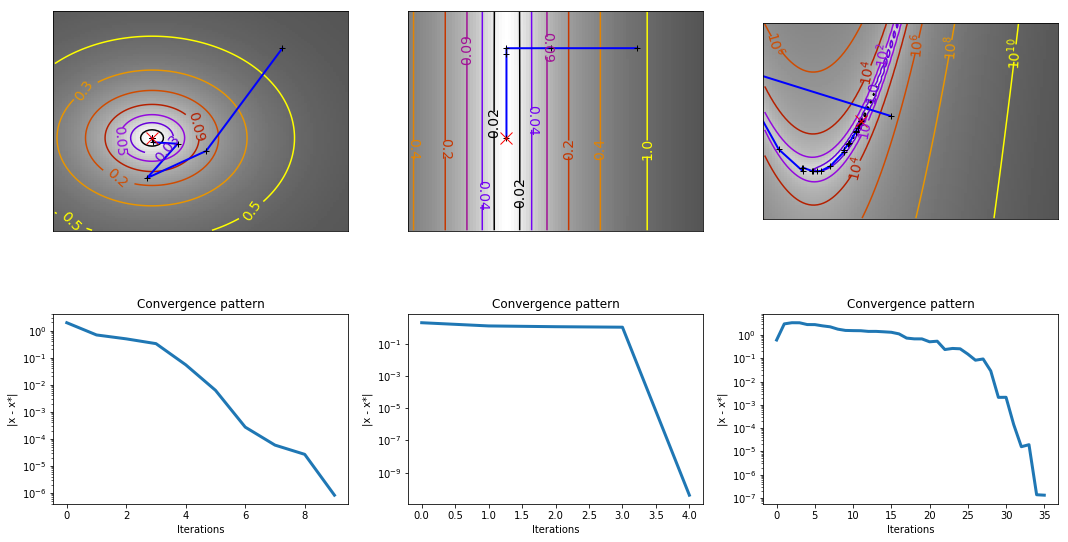

In [14]:
test_solver(lbfgs)

For **Non Convex Gaussian kernel and Badly conditioned quadratic function**, we have almost the same results.

- Like BFGS, L-BFGS does not need exact line search to converge because the number of iterations is small. Indeed, for BFGS, the work per iteration is $O(n^2)$ while LBFGS is $O(mn)$ where $n$ is the number of iteration and $m$ the memory size. Thus, if we have functions which need a small number of iteration to converge, we will not have big difference between BFGS and LBFGS.


- For **Rosenbrock function**, we have better performance. Indeed, LBFGS is a less computationally intensive method than BFGS when the number of iteration is large. The Rosenbrock function needs more iterations to converge so we will have a bigger difference in performances between BFGS and L-BFGS. Moreover, LBFGS uses relatively new information. In the BFGS method, the inverse Hessian contains information from all previous iterates. Thus, we will have "useless" information. That is the case for Rosenbrock function.


**Conclusion:**
- In most cases, LBFGS is the **best quasi-Newton method**. Here as we do not do a lot of iterations, Newton method seems to have good performances. If it takes more iterations, Newton method would be costly as the computation of $H_t^{-1}\nabla f(x_t)$ has a complexity of $O(p^3)$ with p the number of iterations and therefore, we will choose Quasi-Newton methods.


- The result for the different methods can change depending on the input parameters that we set such as c1, c2 or the approximation of step. Moreover, a method can be more suitable than another depending on the function (Example: Newton method for quadratic problem). 